## Problem Statement

This kernel focuses on solving a problem as outlined by the [Costa Rican Household Poverty Level Prediction](https://www.kaggle.com/c/costa-rican-household-poverty-prediction) Kaggle competition.

As per the competition overview page:
> The Inter-American Development Bank is asking the Kaggle community for help with income qualification for some of the world's poorest families. Are you up for the challenge?

Most certainly - let's do this!

## Imports

In [345]:
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
from math import sqrt

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from matplotlib import style
style.use('seaborn')

import os
print(os.listdir("../input"))

%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format

random_state = 5

['train.csv', 'sample_submission.csv', 'test.csv']


## Getting the Data

In [346]:
PATH = '../input/'

In [347]:
files = ['train', 'test', 'sample_submission']
tabs = [pd.read_csv(f'{PATH}{f}.csv', low_memory=False) for f in files]
for t in tabs: display(t.head())

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,"190,000.00",0,3,0,1,1,0,nan,0,...,100,1849,1,100,0,1.00,0.00,100.00,1849,4
1,ID_f29eb3ddd,"135,000.00",0,4,0,1,1,1,1.00,0,...,144,4489,1,144,0,1.00,64.00,144.00,4489,4
2,ID_68de51c94,nan,0,8,0,1,1,0,nan,0,...,121,8464,1,0,0,0.25,64.00,121.00,8464,4
3,ID_d671db89c,"180,000.00",0,5,0,1,1,1,1.00,0,...,81,289,16,121,4,1.78,1.00,121.00,289,4
4,ID_d56d6f5f5,"180,000.00",0,5,0,1,1,1,1.00,0,...,121,1369,16,121,4,1.78,1.00,121.00,1369,4


,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,ID_2f6873615,nan,0,5,0,1,1,0,nan,1,...,4,0,16,9,0,1,2.25,0.25,272.25,16
1,ID_1c78846d2,nan,0,5,0,1,1,0,nan,1,...,41,256,1681,9,0,1,2.25,0.25,272.25,1681
2,ID_e5442cf6a,nan,0,5,0,1,1,0,nan,1,...,41,289,1681,9,0,1,2.25,0.25,272.25,1681
3,ID_a8db26a79,nan,0,14,0,1,1,1,1.00,0,...,59,256,3481,1,256,0,1.00,0.00,256.00,3481
4,ID_a62966799,"175,000.00",0,4,0,1,1,1,1.00,0,...,18,121,324,1,0,1,0.25,64.00,nan,324


,Id,Target
0,ID_2f6873615,4
1,ID_1c78846d2,4
2,ID_e5442cf6a,4
3,ID_a8db26a79,4
4,ID_a62966799,4


In [348]:
train = tabs[0]
train.describe()

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
count,"2,697.00","9,557.00","9,557.00","9,557.00","9,557.00","9,557.00","9,557.00","2,215.00","9,557.00","9,557.00",...,"9,557.00","9,557.00","9,557.00","9,557.00","9,557.00","9,557.00","9,557.00","9,552.00","9,557.00","9,557.00"
mean,"165,231.61",0.04,4.96,0.02,0.99,0.96,0.23,1.40,0.39,1.56,...,74.22,"1,643.77",19.13,53.50,3.84,3.25,3.90,102.59,"1,643.77",3.30
std,"150,457.13",0.19,1.47,0.15,0.07,0.20,0.42,0.76,0.68,1.04,...,76.78,"1,741.20",18.75,78.45,6.95,4.13,12.51,93.52,"1,741.20",1.01
min,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,...,0.00,0.00,1.00,0.00,0.00,0.04,0.00,0.00,0.00,1.00
25%,"80,000.00",0.00,4.00,0.00,1.00,1.00,0.00,1.00,0.00,1.00,...,16.00,289.00,9.00,0.00,0.00,1.00,0.11,36.00,289.00,3.00
50%,"130,000.00",0.00,5.00,0.00,1.00,1.00,0.00,1.00,0.00,1.00,...,36.00,961.00,16.00,36.00,1.00,2.25,0.44,81.00,961.00,4.00
75%,"200,000.00",0.00,6.00,0.00,1.00,1.00,0.00,2.00,1.00,2.00,...,121.00,"2,601.00",25.00,81.00,4.00,4.00,1.78,134.56,"2,601.00",4.00
max,"2,353,477.00",1.00,11.00,1.00,1.00,1.00,1.00,6.00,5.00,8.00,...,441.00,"9,409.00",169.00,441.00,81.00,36.00,64.00,"1,369.00","9,409.00",4.00


In [349]:
test = tabs[1]
test.describe()

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
count,"6,453.00","23,856.00","23,856.00","23,856.00","23,856.00","23,856.00","23,856.00","5,730.00","23,856.00","23,856.00",...,"23,856.00","23,856.00","23,856.00","23,856.00","23,856.00","23,856.00","23,856.00","23,856.00","23,825.00","23,856.00"
mean,"174,872.55",0.05,4.96,0.03,0.99,0.96,0.24,1.35,0.42,1.56,...,34.45,74.45,"1,657.80",19.11,54.09,3.89,3.56,4.17,100.51,"1,657.80"
std,"156,788.71",0.22,1.54,0.17,0.08,0.19,0.43,0.69,0.71,0.99,...,21.70,77.00,"1,753.60",17.31,77.31,6.88,6.67,13.11,89.21,"1,753.60"
min,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.02,0.00,0.00,0.00
25%,"80,000.00",0.00,4.00,0.00,1.00,1.00,0.00,1.00,0.00,1.00,...,16.00,16.00,256.00,9.00,0.00,0.00,1.00,0.11,36.00,256.00
50%,"140,000.00",0.00,5.00,0.00,1.00,1.00,0.00,1.00,0.00,1.00,...,32.00,36.00,"1,024.00",16.00,36.00,1.00,2.25,0.44,75.11,"1,024.00"
75%,"220,000.00",0.00,6.00,0.00,1.00,1.00,0.00,1.75,1.00,2.00,...,51.00,121.00,"2,601.00",25.00,81.00,4.00,4.00,1.78,132.25,"2,601.00"
max,"2,852,700.00",1.00,15.00,1.00,1.00,1.00,1.00,6.00,6.00,7.00,...,97.00,441.00,"9,409.00",169.00,441.00,100.00,169.00,64.00,"1,296.00","9,409.00"


In [350]:
data = [train, test]

In [351]:
for t in data: display(t.shape)

(9557, 143)

(23856, 142)

The training set is almost x2.5 the size of the training set... This is going to be a true challenge!

## Data Review

**Target feature**

We are asked to predict the feature called `Target` - an ordinal variable indicating groups of income levels as follows:
1.  = extreme poverty 
2. = moderate poverty 
3. = vulnerable households 
4. = non vulnerable households

Let's look at the `Target` distribution in our training data:

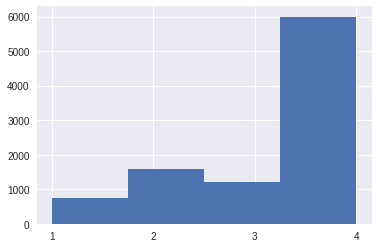

In [352]:
bins = train['Target'].unique()
train['Target'].hist(bins=len(bins))
plt.xticks(bins)
plt.show()

Unsurprisingly, we have an overrepresentation of the non-vulnerable households in our dataset. This was to be expected since normally government aid would be targeted at a minority of households that are in need the most. 

This however poses a difficulty when training a machine learning algorithm since our results will most likely be biased towards forecasting the non-vulnerable households if we do not adress this issue. This problem of an imbalanced dataset is something we'll look into before going into modelling.

**Missing values check**

Some of the features in the training dataset appear to be incomplete:

In [353]:
for t in data: display(t.isna().sum()[t.isna().sum() != 0] / t.shape[0])

v2a1        0.72
v18q1       0.77
rez_esc     0.83
meaneduc    0.00
SQBmeaned   0.00
dtype: float64

v2a1        0.73
v18q1       0.76
rez_esc     0.82
meaneduc    0.00
SQBmeaned   0.00
dtype: float64

The same features are incomplete at a similar rates in both the training and test set, hinting that this might not be a case of data quality issues.

Let's look closer at the features with missing values:
1. `v2a1` - Monthly rent payment
1.  `v18q1` - Number of tablets household owns
1. `rez_esc` - Years behind in school
1. `meaneduc` - Average years of education for adults (18+)
1. `SQBmeaned` - Average years of education for adults squared

Tackling them in turns:

> `rez_esc`

Reviewing the values in years behind in school against the age hints at the reason why so many observations are missing for this feature: the people with missing values are most likely not yet - or no longer - in the education system:

In [354]:
for t in data: display(train[['age', 'rez_esc']].groupby('age').mean().head(25))

,rez_esc
age,
0,nan
1,nan
2,nan
3,nan
4,nan
5,nan
6,nan
7,0.00
8,0.04


,rez_esc
age,
0,nan
1,nan
2,nan
3,nan
4,nan
5,nan
6,nan
7,0.00
8,0.04


We will fill in the missing values with 0:

In [355]:
for t in data: t['rez_esc'].fillna(0, inplace=True)

>`v2a1`

For the monthly rent payment, over 72% of records appear to be missing. One potential explanation for this could be when the family actually owns a house and pays no rent as such. Let's look at some of the other features provided - specifically `tipovivi1-5` which describe the household ownership type:

In [356]:
for t in data:
    mask = t['v2a1'].isna()
    name = "Training" if "Target" in t.columns else "Test"
    print(f"""
{name} Set
__________
Total missing v2a1 observations: {t[mask].shape[0]}

Of which:
> own and fully paid house: {t[mask & (t['tipovivi1'] == 1)].shape[0]}
> own, paying in installments: {t[mask & (t['tipovivi2'] == 1)].shape[0]}
> rented: {t[mask & (t['tipovivi3'] == 1)].shape[0]}
> precarious: {t[mask & (t['tipovivi4'] == 1)].shape[0]}
> other (assigned,  borrowed): {t[mask & (t['tipovivi5'] == 1)].shape[0]}
    """)


Training Set
__________
Total missing v2a1 observations: 6860

Of which:
> own and fully paid house: 5911
> own, paying in installments: 0
> rented: 0
> precarious: 163
> other (assigned,  borrowed): 786
    

Test Set
__________
Total missing v2a1 observations: 17403

Of which:
> own and fully paid house: 14933
> own, paying in installments: 0
> rented: 0
> precarious: 434
> other (assigned,  borrowed): 2036
    


Clearly the majority of cases relate to the family either living in their own house or in an assigned/borrowed house. Again, we will simply fill in the missing values with 0:

In [357]:
for t in data: t['v2a1'].fillna(0, inplace=True)

> `v18q1`

In case of the missing values in the number of tablets a household owns, we also have a supporting feature - namely `v18q` - indicating if a person owns a tablet or not:

In [358]:
train[['v18q1', 'v18q']].fillna('missing').groupby('v18q1').sum()

,v18q
v18q1,
1.0,1586
2.0,444
3.0,129
4.0,37
5.0,13
6.0,6
missing,0


In summary, `v18q1` is only missing when none of the people in the household own a tablet. This means that we can safely fill the missing values with 0 again:

In [359]:
for df in data: df['v18q1'].fillna(0, inplace=True)

> `meaneduc` & `SQBmeaned`

This leaves us with the average years of education for adults and it's squared values. As in previous cases, we'll leverage on the other features to gain the insight. In this case we will use `age` (since there is an age census for this variable) and `escolari`, the years of schooling of a particular person:

In [360]:
for t in data: display(t[['idhogar', 'age', 'escolari']][t['meaneduc'].isna()])

,idhogar,age,escolari
1291,1b31fd159,18,10
1840,a874b7ce7,18,6
1841,a874b7ce7,18,4
2049,faaebf71a,19,12
2050,faaebf71a,19,12


,idhogar,age,escolari
4,1e2fc704e,18,11
535,bb7038e41,18,11
536,4937daf94,19,12
537,4937daf94,19,12
2612,4deb0c65e,19,8
2613,4deb0c65e,17,6
6809,74718009d,18,12
6810,74718009d,19,12
7266,8e4c4b74b,19,12
7267,8e4c4b74b,18,10


It seems there is a mix of adults and non-adults in the families in the test set. Therefore, to fill in the missing values we will use the average years of schooling (`escolari`) of the adults or 0 if there are none in the household.

In [361]:
for t in data:
    di = dict(t[['idhogar', 'escolari']][(t['meaneduc'].isna()) & (t['age'] >= 18)].groupby('idhogar').mean()['escolari'])
    no18 = set(t['idhogar'][t['meaneduc'].isna()]) - set([x for x in di])
    di.update([[x, 0] for x in no18])
    for d in di:
        t.loc[(t['idhogar'] == d), 'meaneduc'] = di[d]
        t.loc[(t['idhogar'] == d), 'SQBmeaned'] = di[d]**2

By now, we should be rid of all the missing values - let's verify this is the case:

In [362]:
for t in data: display(t.isna().sum().sum())

0

0

**Handling categorical data**

Before we proceed to modelling, we need to ensure all of the features we plan to use in modelling are numerical. `Id` and `idhogar` are certainly string values but this doesn't bother us as they will not be used in training of the model. 

However, there are some other non-numerical features in our dataset as well: 

In [363]:
cats = set()
for t in data: cats.update({var for var in t.drop(columns=['Id', 'idhogar']).columns if t[var].dtypes == "O"})
cats

{'dependency', 'edjefa', 'edjefe'}

Time to see what sort of features we're up against here:
1. `dependency` - dependency rate
1. `edjefe` - years of education of male head of household
1. `edjefa` - years of education of female head of household

In [364]:
for c in cats: display(c, train[c].unique())

'dependency'

array(['no', '8', 'yes', '3', '.5', '.25', '2', '.66666669', '.33333334',
       '1.5', '.40000001', '.75', '1.25', '.2', '2.5', '1.2', '4',
       '1.3333334', '2.25', '.22222222', '5', '.83333331', '.80000001',
       '6', '3.5', '1.6666666', '.2857143', '1.75', '.71428573',
       '.16666667', '.60000002'], dtype=object)

'edjefe'

array(['10', '12', 'no', '11', '9', '15', '4', '6', '8', '17', '7', '16',
       '14', '5', '21', '2', '19', 'yes', '3', '18', '13', '20'],
      dtype=object)

'edjefa'

array(['no', '11', '4', '10', '9', '15', '7', '14', '13', '8', '17', '6',
       '5', '3', '16', '19', 'yes', '21', '12', '2', '20', '18'],
      dtype=object)

The categorical features in our dataset appear to actually be continuous with some observations noted as "yes" or "no" instead of numbers. Let's look at them a little closer, starting with:

>`edjefe` & `edjefa`

In order to understand the 'yes' and 'no' observations, we will compare them with some of the other features in our dataset. 

Let's look at the family heads first:

In [365]:
select = ['idhogar', 'parentesco1', 'male', 'escolari', 'edjefe', 'edjefa', 'SQBedjefe']
for t in data: display(t[select][t['parentesco1'] ==1].head(10))

,idhogar,parentesco1,male,escolari,edjefe,edjefa,SQBedjefe
0,21eb7fcc1,1,1,10,10,no,100
1,0e5d7a658,1,1,12,12,no,144
2,2c7317ea8,1,0,11,no,11,0
5,2b58d945f,1,1,11,11,no,121
8,d6dae86b7,1,1,9,9,no,81
12,bb2094100,1,0,11,no,11,0
13,c51f9c774,1,0,4,no,4,0
18,6893e65ca,1,0,10,no,10,0
20,d29058053,1,1,15,15,no,225
21,ec0e8edce,1,1,4,4,no,16


,idhogar,parentesco1,male,escolari,edjefe,edjefa,SQBedjefe
2,72958b30c,1,0,17,no,17,0
3,5b598fbc9,1,1,16,16,no,256
4,1e2fc704e,1,0,11,no,11,0
6,8ee7365a8,1,0,11,no,11,0
8,ff69a6fc8,1,0,14,no,14,0
9,b61e2bb92,1,0,10,no,10,0
12,a499b6c30,1,0,15,no,15,0
13,f751b9e44,1,1,10,10,no,100
21,ba1262b51,1,1,6,6,no,36
23,d5a0a19d8,1,0,9,no,9,0


It appears that for family heads, we basically get 'no' for `edjefa` if the head is a male and a 'no' for `edjefe` if the head is a female. Let's verify:

In [366]:
for t in data: 
    for f in ['edjefe', 'edjefa']: display(t[[f, 'male']][(t[f] == 'no') & (t['parentesco1'] == 1)].groupby('male').count())

,edjefe
male,
0,1163
1,74


,edjefa
male,
0,61
1,1810


,edjefe
male,
0,2753
1,237


,edjefa
male,
0,120
1,4581


There seem to be some cases where there's a 'no' in `edjefe` when the head is a male and in `edjefa` when the head is a female. Let's check the average years of education is such cases:

In [367]:
for t in data:
    display(t[['escolari', 'edjefe', 'edjefa']][(t['parentesco1'] == 1) &
                                        (((t['edjefe'] == 'no') & (t['male'] == 1)) 
                                         | ((t['edjefa'] == 'no') & (t['male'] == 0)))
                                       ].groupby(['edjefe', 'edjefa']).mean())

,,escolari
edjefe,edjefa,
no,no,0


,,escolari
edjefe,edjefa,
no,no,0


Ok, it looks like there are cases when both `edjefe` and `edjefa` have the value 'no' - it seems to be when the family head spent no time in education.

Let's check the 'yes' cases now:

In [368]:
for t in data: 
    display(t[select][t['edjefe'] == 'yes'].head(10))
    display(t[select][t['edjefa'] == 'yes'].head(10))

,idhogar,parentesco1,male,escolari,edjefe,edjefa,SQBedjefe
601,3641ce2d1,1,1,1,yes,no,1
602,3641ce2d1,0,0,3,yes,no,1
2392,a7abf59cc,0,0,6,yes,no,1
2393,a7abf59cc,0,0,5,yes,no,1
2394,a7abf59cc,1,1,1,yes,no,1
2422,698318dd7,0,1,6,yes,no,1
2423,698318dd7,0,0,1,yes,no,1
2424,698318dd7,1,1,1,yes,no,1
2829,4559a5af0,0,0,4,yes,no,1
2830,4559a5af0,1,1,1,yes,no,1


,idhogar,parentesco1,male,escolari,edjefe,edjefa,SQBedjefe
432,39f697073,1,0,1,no,yes,0
566,5f1665f1d,0,0,0,no,yes,0
567,5f1665f1d,0,1,6,no,yes,0
568,5f1665f1d,1,0,1,no,yes,0
569,5f1665f1d,0,0,7,no,yes,0
594,10949c36b,0,1,1,no,yes,0
595,10949c36b,1,0,1,no,yes,0
974,4ec0576ea,0,1,10,no,yes,0
975,4ec0576ea,0,1,9,no,yes,0
976,4ec0576ea,1,0,1,no,yes,0


,idhogar,parentesco1,male,escolari,edjefe,edjefa,SQBedjefe
1272,b49c7116c,0,0,4,yes,no,1
1273,b49c7116c,1,1,1,yes,no,1
1463,1d5d06b34,1,1,1,yes,no,1
1464,1d5d06b34,0,0,6,yes,no,1
1857,a503f4c31,1,1,1,yes,no,1
1858,a503f4c31,0,0,3,yes,no,1
1896,8c2bc79f1,1,1,1,yes,no,1
1897,8c2bc79f1,0,0,6,yes,no,1
1908,ab0f9933d,0,0,7,yes,no,1
1909,ab0f9933d,1,1,1,yes,no,1


,idhogar,parentesco1,male,escolari,edjefe,edjefa,SQBedjefe
362,5a5367b00,0,1,0,no,yes,0
363,5a5367b00,0,1,6,no,yes,0
364,5a5367b00,0,1,6,no,yes,0
365,5a5367b00,1,0,1,no,yes,0
366,5a5367b00,0,0,5,no,yes,0
367,5a5367b00,0,0,0,no,yes,0
1116,b93509b16,1,0,1,no,yes,0
2510,35752af09,1,0,1,no,yes,0
2511,35752af09,0,1,8,no,yes,0
2726,8e9d86331,1,0,1,no,yes,0


The 'yes' in both `edjefe` and `edjefa` seems to indicate that this family head has 1 year of education. Let's verify:

In [369]:
for t in data:    
    for f in ['edjefe', 'edjefa']:
        display(t[[f, 'escolari']][(t[f] == 'yes') & (t['parentesco1'] == 1)].groupby(f).mean())

,escolari
edjefe,
yes,1


,escolari
edjefa,
yes,1


,escolari
edjefe,
yes,1


,escolari
edjefa,
yes,1


Apparently, there also seem to be cases of households with no family heads - in this case both `edjefe` and `edjefa` are also a 'no':

In [370]:
for t in data: display(t[select][(t['edjefa'] == 'no') & (t['edjefe'] == 'no') & (t['parentesco1'] == 0)].head(10))

,idhogar,parentesco1,male,escolari,edjefe,edjefa,SQBedjefe
87,2b1a06ddc,0,1,13,no,no,0
121,d9e9b591a,0,0,14,no,no,0
122,d9e9b591a,0,1,8,no,no,0
123,d9e9b591a,0,0,9,no,no,0
125,d9e9b591a,0,0,14,no,no,0
166,71bec40bc,0,0,0,no,no,0
167,71bec40bc,0,1,1,no,no,0
168,71bec40bc,0,0,5,no,no,0
169,71bec40bc,0,0,6,no,no,0
170,71bec40bc,0,0,0,no,no,0


,idhogar,parentesco1,male,escolari,edjefe,edjefa,SQBedjefe
381,2d8da9345,0,0,9,no,no,0
383,2d8da9345,0,0,7,no,no,0
384,2d8da9345,0,0,7,no,no,0
419,decc8d8a0,0,1,11,no,no,0
439,b39a96e5e,0,0,3,no,no,0
459,c4fec626a,0,1,3,no,no,0
618,4d6cba397,0,1,6,no,no,0
619,4d6cba397,0,0,0,no,no,0
620,4d6cba397,0,1,11,no,no,0
621,4d6cba397,0,0,0,no,no,0


Inspired by colleagues in this Kaggle competition, we will deal with this issue by replacing `edjefe` and `edjefa` with a single feature that we will name `edjef` - this feature will indicate the years of education of the head of the house, irrispective of the sex (0 if there is none):

In [371]:
for t in data:
    di = dict(t[['idhogar', 'escolari']][t['parentesco1'] == 1].values)
    pe = t[['idhogar', 'parentesco1']].groupby('idhogar').agg('max')
    di.update(dict(pe[pe['parentesco1'] != 1]['parentesco1']))
    t['edjef'] = t['idhogar'].map(lambda x: di[x])
    t.drop(columns=['edjefe', 'edjefa'], inplace=True)

> `dependency`

In case of this feature we also have a squared value (`SQBdependancy`) to help us with the interpretation:

In [372]:
for t in data: display(t[['dependency', 'SQBdependency']][t['dependency']
                                                              .isin(['yes', 'no'])].groupby('dependency').agg(['min', 'mean', 'max']))

SQBdependency          
                     min mean  max
dependency                        
no                  0.00 0.00 0.00
yes                 1.00 1.00 1.00

SQBdependency          
                     min mean  max
dependency                        
no                  0.00 0.00 0.00
yes                 1.00 1.00 1.00

Easily enough, we should interpret 'yes' as 1 (i.e. full dependancy) and 'no' as 0:

In [373]:
for t in data:
    t.loc[t['dependency'] == 'yes', 'dependency'] = 1
    t.loc[t['dependency'] == 'no', 'dependency'] = 0
    t['dependency'] = t['dependency'].astype('float')

And for a final check to verify that we dealt with all non-numerical features...

In [374]:
for t in data: display([var for var in t.drop(columns=['Id', 'idhogar']).columns if t[var].dtypes == "O"])

[]

[]

**Aggregating the dataset**

As per the competition rules, the entries will be evaluated at household (identified through the family head) - and not individual - level. This means aggregating our dataset at household level for model training purposes should be a wise choice.

In order to do that, we must understand how to aggregate the individual features that we have. To do this effectively, we'll split them into buckets. The approach taken here has largely been inspired by [Will Koehrsen's kernel](https://www.kaggle.com/willkoehrsen/start-here-a-complete-walkthrough).

We start off with the features that will not be used as independant variables in the training but are essential to infer from the test set:

In [375]:
id_ = ['Id', 'idhogar', 'Target']

Then we group the features that refer to individuals and as such will require a form of aggregation. Within this group we distinct between boolean and ordered continuous features as the approach in aggregating these will differ:

In [376]:
ind_bool = ['v18q', 'dis', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 
            'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
            'parentesco1', 'parentesco2',  'parentesco3', 'parentesco4', 'parentesco5', 
            'parentesco6', 'parentesco7', 'parentesco8',  'parentesco9', 'parentesco10', 
            'parentesco11', 'parentesco12', 'instlevel1', 'instlevel2', 'instlevel3', 
            'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 
            'instlevel9', 'mobilephone']

ind_ordered = ['rez_esc', 'escolari', 'age']

Then we have the squared features. Since we will be using a neural network to model the data, removing these from training can prove to be not only possible but even beneficial due to getting rid of potential issues related to collinearity:

In [377]:
sqr_ = ['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 
        'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq']

The rest of the variables in our dataset are already at household level so we can take them as is from the household heads observations.

In order to perform the aggregation effectively, we will temporarily merge the training and test sets into a single frame:

In [378]:
train_orig = train.copy()
test_orig = test.copy()

In [379]:
frame = test.copy()
frame['Target'] = np.nan
frame = frame.append(train)

We start off by reducing the dataset to family heads only and excluding the individual and squared features:

In [380]:
frame_agg = frame[frame['parentesco1'] == 1].drop(columns=(sqr_ + ind_bool + ind_ordered))

Now, time to create the aggregated individual features. We'll start with the ordered continuous ones, which will be transfomed into household aggregates: minimum, average, maximum and combined values:

In [381]:
def agg_features(feats, agg=['min', 'mean', 'max', 'sum']):
    global frame_agg
    ind_agg = frame[['idhogar'] + feats].groupby('idhogar').agg(agg)
    new_cols = []
    for col in ind_agg.columns.levels[0]:
        for stat in ind_agg.columns.levels[1]:
            new_cols.append(f'{col}_{stat}')

    ind_agg.columns = new_cols
    ind_agg.reset_index(inplace=True)
    frame_agg = frame_agg.merge(ind_agg, on='idhogar', how='left')

In [382]:
agg_features(ind_ordered, agg=['min', 'mean', 'max', 'sum'])

For the boolean individual features we will not need the minimum and maximum values (by definition 0 and 1 for all of them), we'll retain the average and combined household values though:

In [383]:
agg_features(ind_bool, agg=['mean', 'sum'])

To further limit collinearity issues, we'll get rid of features that are 99% correlated: 

In [384]:
corr_matrix = frame_agg.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] >= 0.99)]
to_drop

['area2',
 'hogar_total',
 'r4t3',
 'tamhog',
 'male_sum',
 'female_mean',
 'female_sum']

Conclusions:
1. Not surprisingly, the male and female features are practicaly collinear - it makes a lot of sense to keep just one version.
1. `hogar_total`, `tamhog` and `r4t3` are duplications of `hhsize`. 
1. `area2` is perfectly collinear with `area1`

In light of this, we will now dispose of these variables from our set:

In [385]:
frame_agg.drop(columns=to_drop, inplace=True)

The final step here is to split up the frame back to the train and test sets using `Target` to differentiate between the two:

In [386]:
test = frame_agg[frame_agg['Target'].isna()].drop(columns='Target').copy()
train = frame_agg[~frame_agg['Target'].isna()].copy()

## Balancing the Training Dataset

As mentioned earlier, before doing any modelling we will need to balance the training dataset. There are various ways to go about this issue. The method chosen for this kernel is performing oversampling of the minority classes with the aid fo k-means clustering, described at length - along with other possible methodologies - [here](https://www.analyticsvidhya.com/blog/2017/03/imbalanced-classification-problem/).

The basic idea here is that instead of random oversampling of our minority classes (`Target` 1, 2 and 3), we will identify clusters of similar observations within these groups and oversample to a point where the clusters are of equal size. Our primary focus is to have a similar number of observations for all classes, therefore as a point of reference we will enlarge the minority classes to the size of the largest cluster identified in the majority class (`Target` 4). 


**K-means clustering**

We will start off by analysing the training set by looking at each `Target` group individually and finding potential clusters within these groups. We will identify the number of such clusters by using the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)):

In [387]:
from sklearn.cluster import KMeans

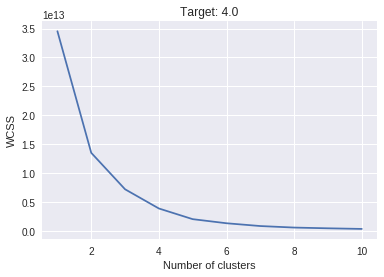

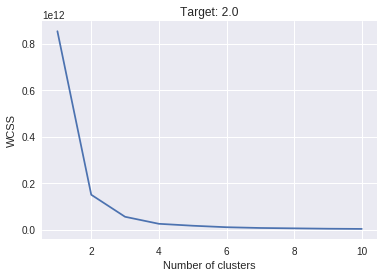

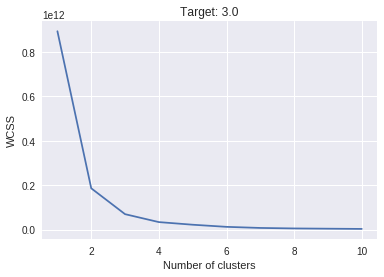

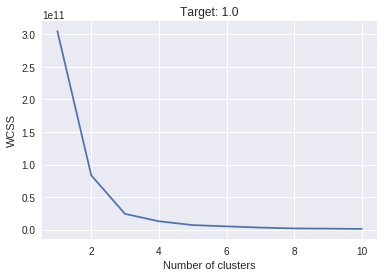

In [388]:
for t in train["Target"].unique():
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state=random_state)
        kmeans.fit(train.drop(columns=['Id', 'idhogar'])[train["Target"] == t])
        wcss.append(kmeans.inertia_)
    fig = plt.figure()
    plt.plot(range(1,11), wcss)
    plt.title(f'Target: {t}')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
plt.show()

Based on the above results, our largest group (`Target` = 4) will be split into 6 clusters and the remaining ones into 2 each:

In [389]:
def cluster(kmeans_groups):
    di = {}
    for group in kmeans_groups:
        kmeans = KMeans(n_clusters = group[1], init = 'k-means++', max_iter = 300, n_init = 10, random_state=random_state)
        di.update(dict(zip(train.index[train['Target'] == group[0]], 
                           [f'{group[0]}_{k}' for k in kmeans.fit_predict(train.drop(columns=['Id', 'idhogar'])[train['Target'] == group[0]])])))
    train['clusters'] = train.index.map(lambda x: di[x])

kmeans_groups = [[1, 2], [2, 2], [3, 2], [4, 6]]

cluster(kmeans_groups)

Let's review our newly identified cluster by number of observations:

In [390]:
train[['Target', 'clusters', 'v2a1']].groupby(['Target', 'clusters']).agg(['count', 'mean'])

v2a1             
                count         mean
Target clusters                   
1.00   1_0        200     3,784.16
       1_1         22   109,495.27
2.00   2_0         63   116,187.87
       2_1        379     2,078.76
3.00   3_0         50   131,853.22
       3_1        305     3,531.15
4.00   4_0       1451     3,415.17
       4_1         52   489,098.25
       4_2        323   138,085.52
       4_3          1 2,353,477.00
       4_4         10   822,230.70
       4_5        117   285,539.29

The 4_3 cluster looks unusually small - only 1 observation! Let's take a closer look:

In [391]:
cl = '4_3'

train['idhogar'][train['clusters'] == cl]

8722    563cc81b7
Name: idhogar, dtype: object

In [392]:
for t in [train[train['clusters'] == cl], train]: display(t.describe())

,Target,abastaguadentro,abastaguafuera,abastaguano,area1,bedrooms,cielorazo,computer,coopele,dependency,...,instlevel6_mean,instlevel6_sum,instlevel7_mean,instlevel7_sum,instlevel8_mean,instlevel8_sum,instlevel9_mean,instlevel9_sum,mobilephone_mean,mobilephone_sum
count,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
mean,4.00,1.00,0.00,0.00,1.00,6.00,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.50,1.00,0.50,1.00,1.00,2.00
std,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
min,4.00,1.00,0.00,0.00,1.00,6.00,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.50,1.00,0.50,1.00,1.00,2.00
25%,4.00,1.00,0.00,0.00,1.00,6.00,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.50,1.00,0.50,1.00,1.00,2.00
50%,4.00,1.00,0.00,0.00,1.00,6.00,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.50,1.00,0.50,1.00,1.00,2.00
75%,4.00,1.00,0.00,0.00,1.00,6.00,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.50,1.00,0.50,1.00,1.00,2.00
max,4.00,1.00,0.00,0.00,1.00,6.00,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.50,1.00,0.50,1.00,1.00,2.00


,Target,abastaguadentro,abastaguafuera,abastaguano,area1,bedrooms,cielorazo,computer,coopele,dependency,...,instlevel6_mean,instlevel6_sum,instlevel7_mean,instlevel7_sum,instlevel8_mean,instlevel8_sum,instlevel9_mean,instlevel9_sum,mobilephone_mean,mobilephone_sum
count,"2,973.00","2,973.00","2,973.00","2,973.00","2,973.00","2,973.00","2,973.00","2,973.00","2,973.00","2,973.00",...,"2,973.00","2,973.00","2,973.00","2,973.00","2,973.00","2,973.00","2,973.00","2,973.00","2,973.00","2,973.00"
mean,3.36,0.97,0.03,0.00,0.72,2.58,0.69,0.10,0.11,1.33,...,0.01,0.06,0.02,0.05,0.16,0.45,0.02,0.05,0.96,3.13
std,0.99,0.18,0.17,0.06,0.45,0.93,0.46,0.30,0.31,2.15,...,0.07,0.26,0.08,0.24,0.28,0.75,0.11,0.24,0.20,1.67
min,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,3.00,1.00,0.00,0.00,0.00,2.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,2.00
50%,4.00,1.00,0.00,0.00,1.00,3.00,1.00,0.00,0.00,0.50,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,3.00
75%,4.00,1.00,0.00,0.00,1.00,3.00,1.00,0.00,0.00,1.00,...,0.00,0.00,0.00,0.00,0.25,1.00,0.00,0.00,1.00,4.00
max,4.00,1.00,1.00,1.00,1.00,8.00,1.00,1.00,1.00,8.00,...,1.00,3.00,1.00,3.00,1.00,5.00,1.00,2.00,1.00,13.00


Looks like we stumbled upon a very wealthy household, not very representative of our dataset. We will exclude this observation from our dataset as an outlier:

In [393]:
train = train[~(train['idhogar'] == '563cc81b7')].drop(columns='clusters')

Let's rerun the clustering analysis: 

In [394]:
cluster(kmeans_groups)

In [395]:
train[['Target', 'clusters', 'v2a1']].groupby(['Target', 'clusters']).agg(['count', 'mean'])

v2a1           
                count       mean
Target clusters                 
1.00   1_0        200   3,784.16
       1_1         22 109,495.27
2.00   2_0         63 116,187.87
       2_1        379   2,078.76
3.00   3_0         50 131,853.22
       3_1        305   3,531.15
4.00   4_0       1399   1,310.51
       4_1        182 173,512.62
       4_2         52 489,098.25
       4_3         10 822,230.70
       4_4        207  92,939.19
       4_5        103 294,310.78

**Creating the validation set**

Before we move on to oversampling, it will be a good idea to separate the validation set from data we will use in training. To ensure the validation set is representative of the population, we will draw samples applying the split ratio to all clusters individually. The validation set will also remain unbalanced - just like the test set - to make the end results more representative.


In [396]:
split = 0.2
val = []
for c in train['clusters'].unique(): val += list(train['Id'][train['clusters'] == c].sample(frac=split, random_state=random_state))
idxs = train['Id'].isin(val)

In [397]:
t_set = train[~idxs].copy()
v_set = train[idxs].reset_index(drop=True).copy()

t_set.shape, v_set.shape

((2378, 169), (594, 169))

**Oversampling**

Time to perform some oversampling! As mentioned earlier, the minority `Target` classes clusters will be oversampled to match the largest cluster in the set. Within the majority class we will also do some balancing:

In [398]:
def oversample(df):
    d = df.copy()
    max_group = d[['clusters', 'v2a1']].groupby(['clusters']).count().max().values[0]
    for c in d['clusters'].unique():
        ratio = 1 if c[0] != '4' else 3
        to_sample = max(int(max_group/ratio) - d['clusters'][d['clusters'] == c].count(), 0)
        d = d.append(df[df['clusters'] == c].sample(
            n=to_sample, replace=True, random_state=random_state), ignore_index=True)
    return d
             
t_set = oversample(t_set)

In [399]:
t_set.shape, v_set.shape

((9698, 169), (594, 169))

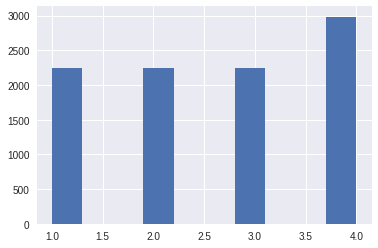

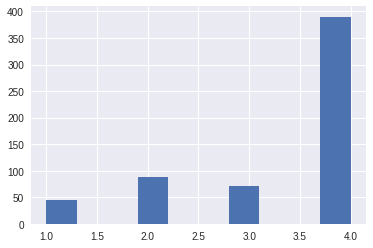

In [400]:
for t in [t_set, v_set]: 
    display(t['Target'].hist())
    plt.figure()
plt.show()

The training set looks to be a lot more balanced now with respect to the `Target` feature.

**Feature scaling and final modelling sets**

Time to prepare the final datasets for training and validation. First, let's dispose of the features that will not be used in modelling:

In [401]:
to_drop = ['Id', 'idhogar', 'parentesco1_mean', 'parentesco1_sum']
X_train = t_set.copy().drop(columns=(to_drop + ['Target', 'clusters']))
X_val = v_set.copy().drop(columns=(to_drop + ['Target', 'clusters']))

Before applying a neural network model it's preferable to apply feature scaling to the input matrix - and this will be our next step:

In [402]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

def to_float(df): 
    for c in df.columns: df[c] = df[c].astype('float64')
    return df

X_train = sc.fit_transform(to_float(X_train))
X_val = sc.transform(to_float(X_val))

Lastly, let's prepare the dependant variable sets:

In [403]:
y_train = t_set['Target'].copy().astype('category').cat.as_ordered().astype('float64') - 1
y_val = v_set['Target'].copy().astype('category').cat.as_ordered().astype('float64') - 1

In [404]:
for t in [X_train, y_train, X_val, y_val]: display(t.shape)

(9698, 163)

(9698,)

(594, 163)

(594,)

## Modelling

As per the competition rules, the results will be evaluated using the macro [F1 score](https://en.wikipedia.org/wiki/F1_score) (surprisingly, not the balanced version).

To keep track of how we are doing during and after training, we will import this metric from sklearn:

In [405]:
from sklearn.metrics import f1_score

This kernel will be focused on modelling using a neural network framework that we will construct using the famous PyTorch library:

In [406]:
import torch as t
import torch.nn as nn
from torch import autograd, optim
import torch.nn.functional as F

**Model architecture**

We start off by defining the model class. To allow some experimentation with the model structure, the number of layers and neurons within layers will be defined by a list where each element represents the number of neurons for a particular layer. We also define a forward method that is executed immediately after class instantiation. 

To limit potential overfitting we will include dropout for all layers of the network. 

To improve training speed and accuracy we will implement batch normalisation at each hidden layer of the network.

In [407]:
class Net(nn.Module):
    
    def __init__(self, X, y, nodes=[200], p=0, act='lrelu'):
        super().__init__()
        self.input_size = X.shape[1]
        self.output_size = int(y.nunique())
        self.nodes = nodes
        self.p = p
        self.act = act
        
        if self.p > 1 or self.p < 0: raise Exception(f"Expected p to be <0,1> but got {self.p}")
        
        if nodes == []: raise Exception("No node sizes input")
        
        self.h1 = nn.Linear(self.input_size, self.nodes[0])       
        self.hid = nn.ModuleList([nn.Linear(self.nodes[i], self.nodes[i + 1]) for i in range(len(self.nodes) - 1)])
        self.out = nn.Linear(self.nodes[-1], self.output_size)
        
        self.bn = nn.ModuleList([nn.BatchNorm1d(self.nodes[i]) for i in range(1, len(self.nodes))])
        
#         for mod in enumerate(self.modules()):
#             if mod[0] > 0: mod[1].weight = nn.init.kaiming_normal(mod[1].weight)
        
        if self.act == 'lrelu': self.act1 = F.leaky_relu
        elif self.act == 'relu': self.act1 = F.relu
        elif self.act == 'tanh': self.act1 = F.tanh
        else: raise Exception("Invalid activation function - choose between lrelu, relu or tanh")
        
        self.act2 = F.softmax
        
    def forward(self, X):
        self.inp = autograd.Variable(t.cuda.FloatTensor(X))
        
        o = self.act1(self.h1(self.inp))
        
        for h, b in zip(self.hid, self.bn):
            o = F.dropout(b(self.act1(h(o))), p=self.p)
        
        o = self.act2(self.out(o), dim=1)
        return o

**Training the model**

Now time to define the model training function. It's basic features are as follows:
* by default, it implements Stochastic Gradient Descent (with index reshuffling at each epoch)
* updates that include the current loss and F1 score on the training and validation sets are printed in epoch intervals specified by `update_cycle`
* the 'standard' training cycle is where parameter adjustment runs for the stated number of epochs and at the stated learning rate
* apart from the standard training, it is possible to define `t_cycles` as an integer higher than the default 1. This will mean that after the standard training, there will be an additional sequence of training cycles, with the number of epochs doubled and learning rate halved at each cycle. This way as we close in on the minimum, we reduce the learning rate to not overshoot.

In [408]:
def train_nn(model, n_epochs=10000, lr=1e-6, bs=900, wd=0, update_cycle=200, use_SGD=True, t_cycles=1, updates=True, cycle_double=True):
    loss_plt = []
    f1s = []
    vf1s = []
    opt = optim.Adam(params=model.parameters(), lr=lr, weight_decay=wd)
    targ = autograd.Variable(t.cuda.FloatTensor(y_train.values).long())

    for i in range(1, t_cycles + 1):
        if t_cycles > 1 and updates: print('='*100, f'\nCycle: {i}, Current Learning Rate: {lr}, Epochs at Cycle: {n_epochs} - updates every {update_cycle} epoch')
        
        for epoch in range(1, n_epochs + 1):
            targ.require_grad = False

            if use_SGD:
                idxs = np.arange(len(X_train))
                np.random.shuffle(idxs)
                for b in range(0, len(X_train), bs):
                    loss = 0
                    targb = autograd.Variable(t.cuda.FloatTensor(y_train.values[idxs[b:b+bs]]).long())
                    targb.require_grad = False
                    out = model(X_train[idxs[b:b+bs]])      
                    loss = F.nll_loss(out, targb)
            else:
                loss = 0
                out = model(X_train)
                loss = F.nll_loss(out, targ)
            
            model.zero_grad()
            loss.backward()
            opt.step()
            if epoch % update_cycle == 0:
                out = model(X_train)
                loss = F.nll_loss(out, targ)
                loss_plt.append(loss.cpu().data.numpy())
                vout = model(X_val)
                f1 = f1_score(y_train.values, out.max(dim=1)[1].cpu().data.numpy(), average='macro')
                vf1 = f1_score(y_val.values, vout.max(dim=1)[1].cpu().data.numpy(), average='macro')
                f1s.append(f1)
                vf1s.append(vf1)
                if updates: print("_"*50,'\n', f'Epoch: {epoch}, Training Loss: {loss.cpu().data.numpy()}, Training F1: {f1}, Validation F1: {vf1}')
        lr /= 10
        if cycle_double: 
            n_epochs *= 2
            update_cycle *= 2
    print(f'Final validation F1: {vf1s[-1:][0]}')
    return model, vf1s[-1:][0]

Before commencing with the training, we will implement a couple of ideas on top of the current framework.

The first one is a quasi-cyclical learning rate, inspired by [this paper](https://arxiv.org/abs/1506.01186). In our implementation this will mean the cycle of gradually reducing the learning rate and increasing the number of epochs described earlier will be repeated a number of times, specified by the `cycles` parameter.

In addition, we will also add in an element of ensamble learning. The training sample is relatively small for neural network training purposes, leading to relatively high variance in the results from a single trained neural network, therefore we will train a number of such networks (specified by `n_models`) and average the predictions over the whole group.

Lastly, the threshold parameter (`stop_threshold`) will indicate the level of the validation F1 score sufficient to cease training of a single network in order to move to training the next one.

We will plot the F1 validation scores of particular models and the average across the group.

In [409]:

def train_ensamble(nodes = [89, 89], p = 0.7, wd = 1e-7, lr = 1e-1, bs = (int(X_train.shape[0] / 4 + 1)),
             t_cycles = 6, epochs_per_cycle = 1, cycle_double = True, cycles = 1, n_models = 31, stop_threshold = 0.46):
    
    global models
    models = []
    for n in range(n_models): models.append(Net(X_train, y_train, nodes=nodes, p=p).cuda())


    # main training loop:
    final_res = []
    mod = 1
    for model in models:
        print('='*50, f'\nMODEL {mod}')
        model.train(mode=True)
        for i in range(1, cycles + 1): 
            print(f'Cycle {i}')
            _, res = train_nn(model, n_epochs = epochs_per_cycle, 
                              lr = lr, bs = bs, wd=wd, update_cycle=epochs_per_cycle, t_cycles = t_cycles, 
                              updates=False, cycle_double=cycle_double)
            if res >= stop_threshold: break
        final_res.append(res)
        mod +=1
    plt.scatter(np.arange(len(final_res)), final_res)
    plt.plot([np.mean(final_res) for a in range(len(final_res))], color='r', linestyle=':')
    plt.show()

MODEL 1
Cycle 1
Final validation F1: 0.3839779532807049
MODEL 2
Cycle 1
Final validation F1: 0.38195025578172564
MODEL 3
Cycle 1
Final validation F1: 0.4017244585391697
MODEL 4
Cycle 1
Final validation F1: 0.37251405055649556
MODEL 5
Cycle 1
Final validation F1: 0.3946619028948415
MODEL 6
Cycle 1
Final validation F1: 0.3690083544073357
MODEL 7
Cycle 1
Final validation F1: 0.3830519137577253
MODEL 8
Cycle 1
Final validation F1: 0.4054151637031457
MODEL 9
Cycle 1
Final validation F1: 0.37500239412004116
MODEL 10
Cycle 1


/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Final validation F1: 0.40037533970696493
MODEL 11
Cycle 1
Final validation F1: 0.39602064027278977
MODEL 12
Cycle 1
Final validation F1: 0.37349354795527956
MODEL 13
Cycle 1
Final validation F1: 0.3939998960609162
MODEL 14
Cycle 1
Final validation F1: 0.37580701394337845
MODEL 15
Cycle 1
Final validation F1: 0.38243367960596963
MODEL 16
Cycle 1
Final validation F1: 0.4187161682739755
MODEL 17
Cycle 1
Final validation F1: 0.37370628181234894
MODEL 18
Cycle 1
Final validation F1: 0.3879779255210766
MODEL 19
Cycle 1
Final validation F1: 0.36636764097049723
MODEL 20
Cycle 1
Final validation F1: 0.37548737105784036
MODEL 21
Cycle 1
Final validation F1: 0.3499692038192552
MODEL 22
Cycle 1
Final validation F1: 0.35658761927866733
MODEL 23
Cycle 1
Final validation F1: 0.40202141787661677
MODEL 24
Cycle 1
Final validation F1: 0.38249968818475244
MODEL 25
Cycle 1
Final validation F1: 0.3669648383004752
MODEL 26
Cycle 1
Final validation F1: 0.4039972315295115
MODEL 27
Cycle 1
Final validation F1:

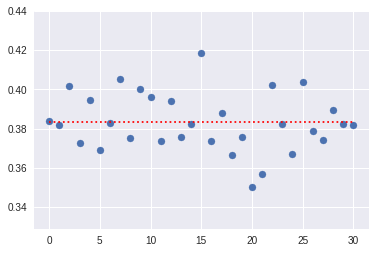

CPU times: user 36 s, sys: 6.21 s, total: 42.2 s
Wall time: 42.2 s


In [410]:
%%time
train_ensamble()

The next step is to define the predict function for the ensamble, which - as mentioned - will basically be an average of predictions across all models:

In [411]:
def ensamble_predict(models, x):
    pred = np.zeros((x.shape[0], 4))
    for model in models: 
        pred += (model.train(mode=False)(x).cpu().data.numpy() / len(models))
    return np.array([pred[r].argmax(axis=0) for r in range(len(pred))])

And now to check the validation F1 score of the ensamble:

In [412]:
f1_score(y_val.values, ensamble_predict(models, X_val), average='macro')

0.40336523740155217

## Reviewing the Results

**Confusion matrix**

Time to review the model results. Firstly, let's look at the confusion matrix:

In [413]:
from sklearn.metrics import confusion_matrix

def conf_mat(targ, preds):
    cm = confusion_matrix(targ, preds)
    cmp = pd.DataFrame(cm)
    cmp.index.name = 'Actuals'
    cmp.columns.name = 'Preds'

    plt.figure(figsize=(5, 5))
    plt.title("CONFUSION MATRIX")
    sns.heatmap(cmp, annot=True, cmap="seismic", fmt='.0f')

    plt.tight_layout()

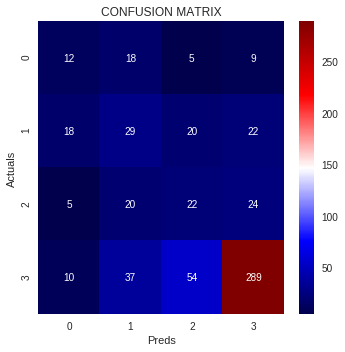

In [414]:
targ = y_val.values
preds = ensamble_predict(models, X_val)

conf_mat(targ, preds)

The results reveal a somewhat low accuracy of the model, in particular in the minority classes. Judging from F1 scores within this ballpark obtained by other participants in the challenge, this is most likely a result of a relatively small sample used for training.

**Feature importance**

Let's review the most important features according to our trained network. The way we define feature importance here is by measuring how much the trainin F1 score deteriorates if a given feature is randomly shuffled and passed along with the rest of the original features through the model. We will order the features by maximum impact and review the top contributors.

In [415]:
scores = []
def f_i(df, num_features = 15):
    global scores
    scores = []
    Xb = to_float(t_set.copy().drop(columns=(to_drop+['Target', 'clusters'])))
    targ = f1_score(y_train.values, ensamble_predict(models, sc.transform(Xb)), average='macro')

    for c in Xb.columns:
        X = Xb.copy()
        X[c] = X[[c]].sample(frac=1, random_state=random_state).set_index(X.index)[c]
        scores.append([c, targ - f1_score(y_train.values, ensamble_predict(models, sc.transform(X)), average='macro')])

    scores = sorted(scores, key=lambda x: x[1], reverse=True)
    pos = np.arange(len(scores))
    scores_names = [x[0] for x in scores]
    scores_f1 = [x[1] for x in scores]

    plt.figure(figsize=(8, 6))
    plt.title('All Features')
    plt.plot(scores_f1)
    plt.tight_layout()
    
    plt.figure(figsize=(8, 6))
    plt.title(f'Top {num_features} Features')
    plt.barh(pos[:num_features], scores_f1[:num_features], align='center')
    plt.yticks(pos[:num_features], scores_names[:num_features])
    plt.gca().invert_yaxis()
    
    plt.show()

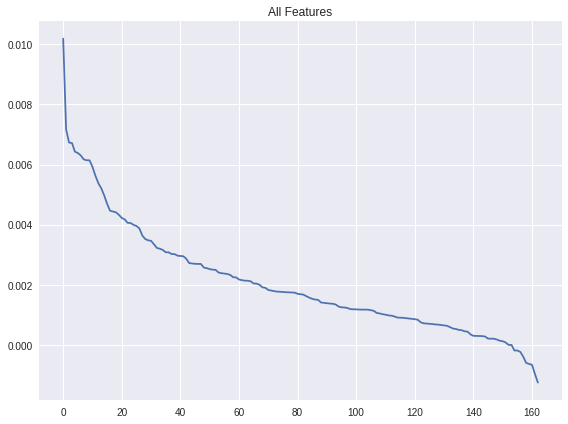

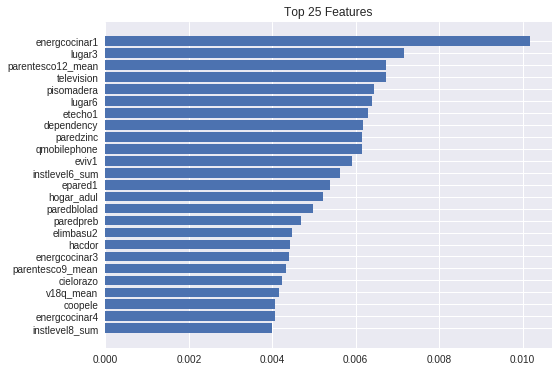

In [416]:
f_i(t_set, num_features=25)

## Prediction on the Test Set

Alright, now it's finally time to use the algorithm on the Test Set. Since the results need to be shared by individual, we will first predict the `Target` for households and then map them to the individuals using `idhogar`:

In [ ]:
X_test = sc.transform(test.drop(columns=to_drop))
di = dict(zip(test['idhogar'], ensamble_predict(models, X_test) + 1))
sub = test_orig[['Id', 'idhogar']].copy()
sub['Target'] = sub['idhogar'].map(di).fillna(4)
sub.drop(columns='idhogar', inplace=True)

Finally, time to prepare the submission csv file:

In [ ]:
from datetime import datetime
now = datetime.now().strftime('%y-%m-%d-%H_%M')

name = f'submission_{now}'
sub = sub.set_index('Id')
sub['Target'] = sub['Target'].astype('int')
sub.to_csv(name + '.csv')

In [ ]:
pd.read_csv(name + '.csv').head()